In [ ]:
# Grab Data and Set up Shop

In [2]:
import os
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Use your real API key here
fred = Fred(api_key="ab546902ed575b0eb5ddfe4b8b4605cf")

start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime.today()

# Pull 2-year and 10-year Treasury yields
dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)
dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)

# Convert to DataFramesource .venv/bin/activate

yields_df = pd.DataFrame({'2yr': dgs2, '10yr': dgs10})
yields_df.dropna(inplace=True)


In [3]:
print(yields_df.head())

             2yr  10yr
2000-01-03  6.38  6.58
2000-01-04  6.30  6.49
2000-01-05  6.38  6.62
2000-01-06  6.35  6.57
2000-01-07  6.31  6.52


In [ ]:


# Construct the Spread
# LGF



In [5]:
yields_df['spread'] = yields_df['10yr'] - yields_df['2yr']
print(yields_df.head())
yields_df[['2yr','10yr','spread']].describe()

             2yr  10yr  spread
2000-01-03  6.38  6.58    0.20
2000-01-04  6.30  6.49    0.19
2000-01-05  6.38  6.62    0.24
2000-01-06  6.35  6.57    0.22
2000-01-07  6.31  6.52    0.21


,2yr,10yr,spread
count,6259.000000,6259.000000,6259.000000
mean,2.200337,3.284597,1.084259
std,1.773467,1.305830,0.983049
min,0.090000,0.520000,-1.080000
25%,0.630000,2.205000,0.210000
50%,1.700000,3.320000,1.140000
75%,3.750000,4.280000,1.910000
max,6.930000,6.790000,2.910000


In [ ]:
# Exploratory Data Analysis

In [6]:
print(yields_df['spread'].describe())

count    6259.000000
mean        1.084259
std         0.983049
min        -1.080000
25%         0.210000
50%         1.140000
75%         1.910000
max         2.910000
Name: spread, dtype: float64


In [ ]:
# Plot the Spread

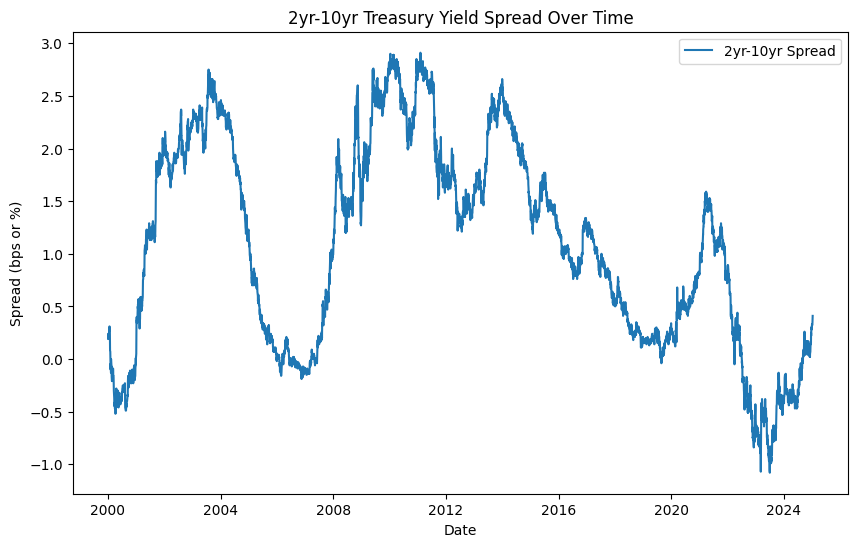

In [7]:
plt.figure(figsize=(10,6))
plt.plot(yields_df.index, yields_df['spread'], label='2yr-10yr Spread')
plt.title('2yr-10yr Treasury Yield Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Spread (bps or %)')
plt.legend()
plt.show()

In [ ]:
# Augmented Dickey-Fuller (ADF) Test:

In [11]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(yields_df['spread'].dropna())
print("ADF Statistic: ", adf_result[0])
print("p-value: ", adf_result[1])


ADF Statistic:  -1.8901278816783114
p-value:  0.33671942345834566


In [ ]:
# Autocorrelation Plots

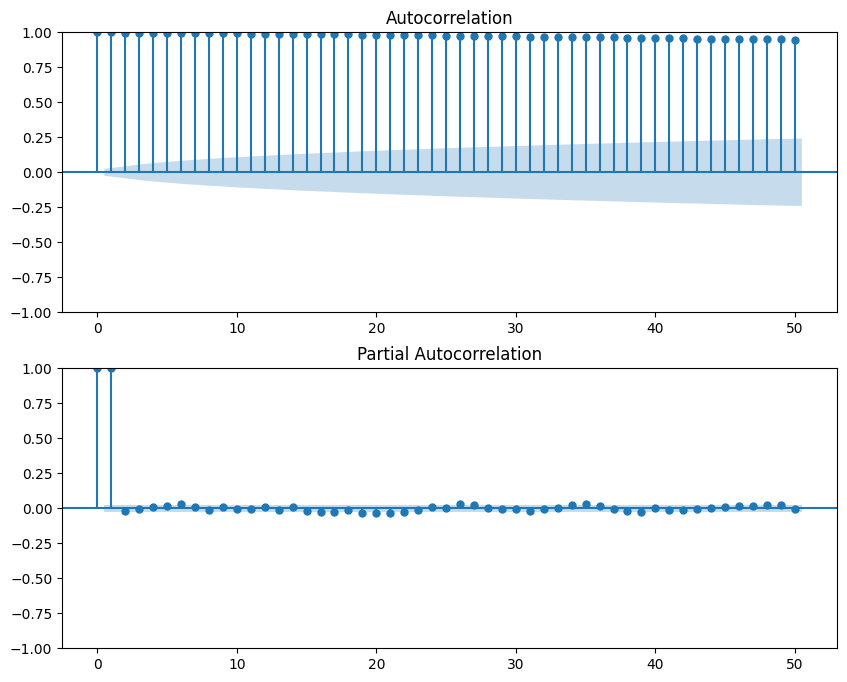

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(yields_df['spread'].dropna(), ax=ax[0], lags=50)
plot_pacf(yields_df['spread'].dropna(), ax=ax[1], lags=50)
plt.show()


In [12]:
import numpy as np
from scipy.optimize import minimize

def ou_neg_log_likelihood(params, spread_series):
    # params = [kappa, theta, sigma]
    kappa, theta, sigma = params
    dt = 1.0  # assume 1 day steps if data is daily
    s = spread_series.values
    n = len(s)

    # Build residuals
    # S_{t+1} - S_t = kappa*(theta - S_t)*dt + noise
    # noise ~ Normal(0, sigma^2 * dt)
    residuals = (s[1:] - s[:-1]) - kappa*(theta - s[:-1])*dt

    # Log-likelihood under normal distribution
    # log L ~ sum of - (residual^2) / (2*sigma^2*dt) - log(sigma*sqrt(dt))
    ll = -0.5*n*np.log(2*np.pi) \
         - (n-1)*np.log(sigma*np.sqrt(dt)) \
         - 0.5*np.sum((residuals**2) / (sigma**2 * dt))
    return -ll  # we use negative for minimization

def estimate_ou_params(spread_series):
    # Initial guesses
    kappa_init = 0.1
    theta_init = spread_series.mean()
    sigma_init = spread_series.std()

    bounds = [(1e-6, None), (None, None), (1e-6, None)]  # avoid zero or negative for kappa, sigma
    result = minimize(ou_neg_log_likelihood,
                      x0=[kappa_init, theta_init, sigma_init],
                      args=(spread_series,),
                      bounds=bounds)
    return result.x  # [kappa, theta, sigma]


In [13]:
spread_data = yields_df['spread'].dropna()
kappa_est, theta_est, sigma_est = estimate_ou_params(spread_data)
print("Estimated kappa =", kappa_est)
print("Estimated theta =", theta_est)
print("Estimated sigma =", sigma_est)


Estimated kappa = 0.0008284108910810086
Estimated theta = 1.1118584743448463
Estimated sigma = 0.03933805053480943


In [ ]:
print(yields_df.head())